Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.

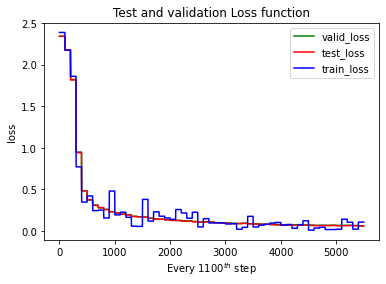

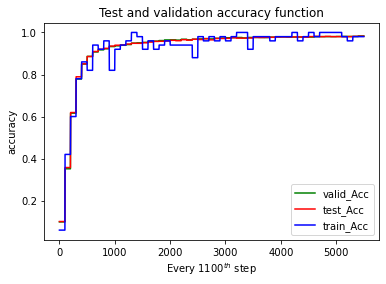

test accuracy 0.9825
The training takes 650.271767 second to finish


In [1]:
import os
import time
import matplotlib.pyplot as plt
import random

import tensorflow as tf

if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()    

# Load MNIST dataset
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

sess = tf.InteractiveSession()
def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    initial = tf.initializers.glorot_uniform()
    W = tf.Variable(initial(shape=shape))
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''
    initial = tf.constant(0.1, shape = shape)
    b = tf.Variable(initial)
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''
    h_conv = tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''
    h_max = tf.nn.max_pool(x, ksize = [1, 2, 2, 1],
                             strides = [1, 2, 2, 1],
                             padding = 'SAME')
    return h_max

def main():
    # Specify training parameters
    result_dir = './results/' # directory where the results from the training are saved
    max_step = 5500 # the maximum iterations. After max_step iterations, the training will stop no matter what
    start_time = time.time() # start timing

    # placeholders for input data and input labeles
    x  = tf.placeholder(tf.float32, [None, 784], name='x')
    y_ = tf.placeholder(tf.float32, [None, 10],  name='y_')

    # reshape the input image
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # first convolutional layer
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.leaky_relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # second convolutional layer
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.leaky_relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # densely connected layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.leaky_relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # softmax
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name = 'y')

    # setup training
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), 
                                                     reduction_indices = [1]))
    train_step = tf.train.MomentumOptimizer(1e-4, 0.99).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accuracy') 
                        
    # scalar summary for the snapshot loss for training.
    tf.summary.scalar(cross_entropy.op.name, cross_entropy)
    #scalar summary for the snapshot accuracy for training:
    tf.summary.scalar(accuracy.op.name, accuracy)

    #summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()

    # Instantiate a SummaryWriter to output summaries and the Graph.
    summary_writer = tf.summary.FileWriter(result_dir, sess.graph)

    # Run the Op to initialize the variables.
    sess.run(init)

    trainLoss = []
    validationLoss = []
    testLoss = []
    trainAcc = []
    validationAcc = []
    testAcc = []
    steps = []
    # run the training
    for i in range(max_step):
        batch = mnist.train.next_batch(50) # make the data batch, which is used in the training iteration.
                                            # the batch size is 50
        if i%100 == 0:
            # output the training accuracy every 100 iterations
            train_accuracy = accuracy.eval(feed_dict = {
                x: batch[0], y_:batch[1], keep_prob: 1.0})
            train_loss = cross_entropy.eval(feed_dict = {
                x: batch[0], y_:batch[1], keep_prob: 1.0})
            #output the test accuracy every 100 iterations
            test_accuracy = accuracy.eval(feed_dict = {
                x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            #output the test loss every 100 iterations
            test_loss = cross_entropy.eval(feed_dict = {
                x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            #output the validation accuracy every 100 iterations
            valid_accuracy = accuracy.eval(feed_dict = {
                x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
            #output the validation loss every 100 iterations
            valid_loss = cross_entropy.eval(feed_dict = {
                x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
            
            print("step {}, training accuracy {}, validation accuracy {}, test accuracy {}".format(i, train_accuracy, valid_accuracy, test_accuracy))
            print("training loss {}, validation loss {}, test loss {}".format(train_loss, valid_loss, test_loss))
            
            
            # Update the events file which is used to monitor the training (in this case,
            # only the training loss is monitored)
            summary_str = sess.run(summary_op, feed_dict={x: batch[0], y_: batch[1], 
                                                          keep_prob: 0.5})           
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()   

        # save the checkpoints every 1100 iterations
        if i % 1100 == 0 or i == max_step:
            checkpoint_file = os.path.join(result_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)
			
        validationLoss.append(valid_loss)
        testLoss.append(test_loss)
        trainLoss.append(train_loss)
        validationAcc.append(valid_accuracy)
        testAcc.append(test_accuracy)
        trainAcc.append(train_accuracy)
        steps.append(i)
        
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5}) # run one train_step
    
    #plot the train, validation and test loss function
    plt.figure()
    plt.plot(steps, validationLoss, 'g-', label = 'valid_loss')
    plt.plot(steps, testLoss, 'r-', label = 'test_loss')
    plt.plot(steps, trainLoss, 'b-', label = 'train_loss')
    plt.title('Test and validation Loss function')
    plt.xlabel('Every $1100^{th}$ step')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    #plot the train, validation and test accuracy
    plt.figure()
    plt.plot(steps, validationAcc, 'g-', label = 'valid_Acc')
    plt.plot(steps, testAcc, 'r-', label = 'test_Acc')
    plt.plot(steps, trainAcc, 'b-', label = 'train_Acc')
    plt.title('Test and validation accuracy function')
    plt.xlabel('Every $1100^{th}$ step')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    # print test error
    print("test accuracy %g"%accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    stop_time = time.time()
    print('The training takes %f second to finish'%(stop_time - start_time))

if __name__ == "__main__":
    main()